In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, balanced_accuracy_score

import numpy as np
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import matplotlib.pyplot as plt
from evaluation import al_results
import scienceplots

plt.style.use("science")

In [4]:
import sys 
sys.path.append("..")

from synthetic_anomalies.generation import anomaly_dataset

output = anomaly_dataset(
    anom_size=1000
)

global_df = output[~((output["label"] == 1) & (output["score"] >= 0)) & ((output["label"] == 1) | (output["label"] == 0))]
contamination_global = len(global_df[global_df["label"] == 1])/len(global_df)
global_df = global_df.to_numpy()

local_df = output[(output["label"] == 0) | (output["label"] == 2)].to_numpy()
contamination_local = len(output[output["label"] == 2])/len(local_df)

cluster_df = output[~((output["label"] == 3) & (output["score"] >= 0)) & ((output["label"] == 3) | (output["label"] == 0))]
contamination_cluster = len(cluster_df[cluster_df["label"] == 3])/len(cluster_df)
cluster_df = cluster_df.to_numpy()

In [5]:
def al_results(data, label, iterations = 10, with_noise=True, noise_level = .25, silent = False):

    label_counts = []
    f1_scores = []
    acc_scores = []
    
    normal, data = np.split(data, [20000])

    for i in np.arange(1, 40, .5):
    
        label_scoresf1 = []
        label_scoresba = []
            
        for _ in range(iterations):
            if with_noise:
                #duplicate_idx = np.random.choice(500, size=100, replace=False)

                noisy_features = data[:, :5] + data[:, -5:] # 3 sigma noise
                
                noisy_features =  np.concatenate([noisy_features]) #, noisy_features[duplicate_idx, 0:5]]) # Add duplicates

                noisy_labels = np.concatenate([data[:, 5]]) #, data[duplicate_idx, 5]])
                
                # Should I make use of training score?
                X_train, X_test, y_train, y_test = train_test_split(
                    noisy_features, 
                    noisy_labels, # score column of dataset
                    test_size=.01*i,
                    stratify=noisy_labels,
                    shuffle=True,
                    #random_seed=42 # Is this a good way to regualarise the peakiness.
                )

                y_train = np.array(y_train/float(label), dtype="int64")
                y_test = np.array(y_test/float(label), dtype="int64")

                X_test = np.concatenate([normal[:, 0:5], X_test])
                y_test = np.concatenate([np.zeros(len(normal[:, 0:5])), y_test])

                
                
                bst = xgb.XGBClassifier(max_depth = 25).fit(X_test, y_test)
                print(len(X_test), y_test.sum())

                y_test_pred = bst.predict(X_train)#rfc.predict(X_train)
                label_scoresf1.append(f1_score(y_train, y_test_pred))
                label_scoresba.append(balanced_accuracy_score(y_train, y_test_pred))

        f1_scores.append(label_scoresf1)
        acc_scores.append(label_scoresba)
        label_counts.append(y_test.sum())
        
    return label_counts, acc_scores, f1_scores, 
    

Global anomaly active learning

In [17]:
glob_label_counts, glob_acc_scores, glob_f1_scores = al_results(
    data = global_df,
    label = 1
)

20305 4.0
20305 4.0
20305 4.0
20305 4.0
20305 4.0
20305 4.0
20305 4.0
20305 4.0
20305 4.0
20305 4.0
20457 6.0
20457 6.0
20457 6.0
20457 6.0
20457 6.0
20457 6.0
20457 6.0
20457 6.0
20457 6.0
20457 6.0
20609 8.0
20609 8.0
20609 8.0
20609 8.0
20609 8.0
20609 8.0
20609 8.0
20609 8.0
20609 8.0
20609 8.0
20761 10.0
20761 10.0
20761 10.0
20761 10.0
20761 10.0
20761 10.0
20761 10.0
20761 10.0
20761 10.0
20761 10.0
20913 12.0
20913 12.0
20913 12.0
20913 12.0
20913 12.0
20913 12.0
20913 12.0
20913 12.0
20913 12.0
20913 12.0
21065 14.0
21065 14.0
21065 14.0
21065 14.0
21065 14.0
21065 14.0
21065 14.0
21065 14.0
21065 14.0
21065 14.0
21217 16.0
21217 16.0
21217 16.0
21217 16.0
21217 16.0
21217 16.0
21217 16.0
21217 16.0
21217 16.0
21217 16.0
21369 18.0
21369 18.0
21369 18.0
21369 18.0
21369 18.0
21369 18.0
21369 18.0
21369 18.0
21369 18.0
21369 18.0
21521 20.0
21521 20.0
21521 20.0
21521 20.0
21521 20.0
21521 20.0
21521 20.0
21521 20.0
21521 20.0
21521 20.0
21673 22.0
21673 22.0
21673 22.0
21673 2

In [18]:
best_unsupervised_acc = 0.812
best_unsupervised_f1 = 0.623

upper_quartile_unsupervised_acc = 0.724203
upper_quartile_unsupervised_f1 = 0.449354

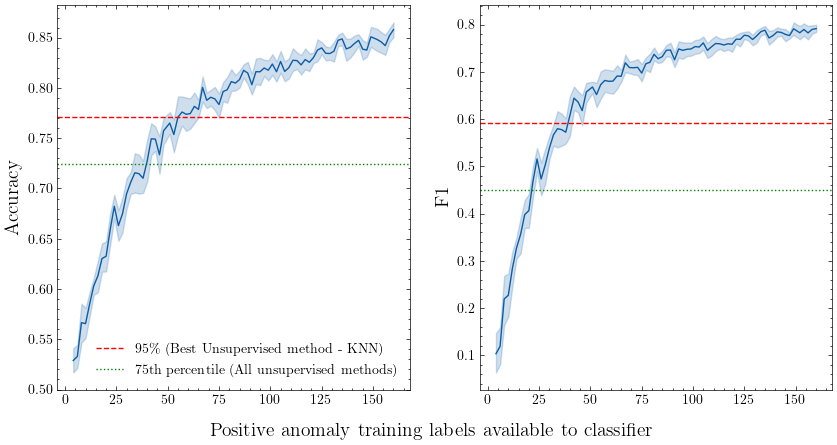

In [19]:
import pandas as pd
import seaborn as sns

rows = []
for idx, (i, j, k) in enumerate(zip(glob_label_counts, glob_acc_scores, glob_f1_scores)):
    for l in range(10):
        rows.append([i, j[l], k[l]])

data = pd.DataFrame(rows, columns = ["labels", "acc", "f1"])

fig, ax = plt.subplots(1,2, figsize=(10, 5))
sns.lineplot(
    data = data,
    x = "labels",
    y = "acc",
    ax = ax[0],
)
ax[0].set_ylabel("Accuracy", fontsize = 14)
ax[0].set_xlabel("")

ax[0].axhline(best_unsupervised_acc*0.95, c="r", ls="--", label=r"95$\%$ (Best Unsupervised method - KNN)")
ax[0].axhline(upper_quartile_unsupervised_acc, c="g", ls=":", label="75th percentile (All unsupervised methods)")
'''ax[0].annotate(text=r"95$\%$ (Best method)", xy=(100, best_unsupervised_acc*0.955), textcoords="data", fontsize=12, color="red")
ax[0].annotate(text="75$\%$ (All methods)", xy=(100, upper_quartile_unsupervised_acc*1.005), textcoords="data", fontsize=12, color="green")
'''

sns.lineplot(
    data = data,
    x = "labels",
    y = "f1",
    ax = ax[1]
)

ax[1].set_ylabel("F1", fontsize = 14)
ax[1].set_xlabel("")
ax[1].axhline(best_unsupervised_f1*0.95, c="r", ls="--")
'''plt.annotate(text=r"95$\%$ (Best method)", xy=(100, best_unsupervised_f1*0.96), textcoords="data", fontsize=12, color="red")
plt.annotate(text="75$\%$ (All methods)", xy=(100, upper_quartile_unsupervised_f1*1.02), textcoords="data", fontsize=12, color="green")
'''
ax[1].axhline(upper_quartile_unsupervised_f1, c="green", ls=":", label="75th percentile of unsupervised methods")

ax[0].legend(loc="lower right", fontsize=10)
fig.supxlabel("Positive anomaly training labels available to classifier", fontsize=14)

# Add more classifier models, Random forest - linear regression etc.

plt.savefig("al_.png", dpi=300)

In [22]:
print("How much active learning must be done to achieve the supervised anomaly detection performance on the best supervised model?")
print(f"90% accuracy of the kNN: {glob_label_counts[np.argwhere(np.mean(glob_acc_scores, axis=1) > 0.9*best_unsupervised_acc)[0][0]]} labels")
print(f"95% accuracy of the kNN: {glob_label_counts[np.argwhere(np.mean(glob_acc_scores, axis=1) > 0.95*best_unsupervised_acc)[0][0]]} labels")
print(f"100% accuracy of the kNN: {glob_label_counts[np.argwhere(np.mean(glob_acc_scores, axis=1) > best_unsupervised_acc)[0][0]]} labels")

How much active learning must be done to achieve the supervised anomaly detection performance on the best supervised model?
90% accuracy of the kNN: 42.0 labels
95% accuracy of the kNN: 57.0 labels
100% accuracy of the kNN: 87.0 labels


In [21]:
print("How much active learning must be done to achieve the supervised anomaly detection performance on the best unsupervised model?")
print(f"90% f1 of the kNN: {glob_label_counts[np.argwhere(np.mean(glob_f1_scores, axis=1) > 0.9*best_unsupervised_f1)[0][0]]} labels")
print(f"95% f1 of the kNN: {glob_label_counts[np.argwhere(np.mean(glob_f1_scores, axis=1) > 0.95*best_unsupervised_f1)[0][0]]} labels")
print(f"100% f1 of the kNN: {glob_label_counts[np.argwhere(np.mean(glob_f1_scores, axis=1) > best_unsupervised_f1)[0][0]]} labels")

print("With LSST, we get lost in the size. Really, we should marvel at the potential for finding patterns in small sets of high quality.")

How much active learning must be done to achieve the supervised anomaly detection performance on the best unsupervised model?
90% f1 of the kNN: 32.0 labels
95% f1 of the kNN: 40.0 labels
100% f1 of the kNN: 42.0 labels
With LSST, we get lost in the size. Really, we should marvel at the potential for finding patterns in small sets of high quality.


In [8]:
# What happens when I increase the proportion of of anom dist.
# IE add more points from an unseen pool that may or may not be anomalies
# How does that effect performance.

Cluster anomaly active learning

In [9]:
label_counts, acc_scores, f1_scores = al_results(
    data = cluster_df,
    label = 3
)

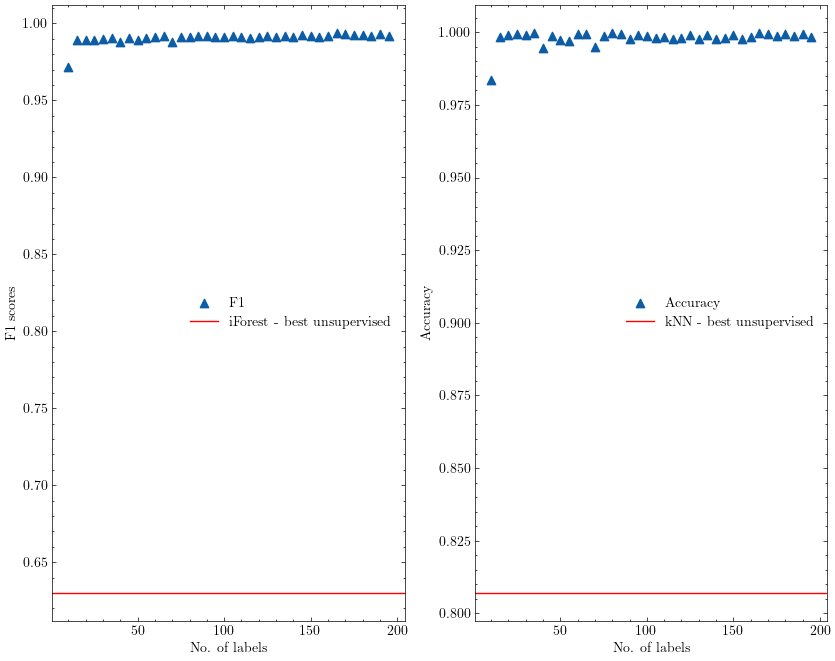

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].scatter(
    label_counts,
    f1_scores,
    label="F1",
    marker="^"
)

ax[0].axhline(0.630, c="r", label="iForest - best unsupervised")
#ax[0].axhline(0.704759, c="g", label="iForest")

ax[0].set_ylabel("F1 scores")
ax[0].set_xlabel("No. of labels")
ax[0].legend()

ax[1].scatter(
    label_counts,
    acc_scores,
    label="Accuracy",
    marker="^"
)
ax[1].axhline(0.807, c="r",  ls="--", label="iForest - best unsupervised")
#ax[1].axhline(0.849143, c="g", label="iForest")

ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("No. of labels")
ax[1].legend()


In [11]:
print("How much active learning must be done to achieve the supervised anomaly detection performance on the best unsupervised model?")
print(f"90% f1 of the iForest: {label_counts[np.argwhere(np.array(f1_scores) > 0.9*0.758590)[0][0]]} labels")
print(f"95% f1 of the iForest: {label_counts[np.argwhere(np.array(f1_scores) > 0.95*0.758590)[0][0]]} labels")
print(f"100% f1 of the iForest: {label_counts[np.argwhere(np.array(f1_scores) > 0.758590)[0][0]]} labels")

How much active learning must be done to achieve the supervised anomaly detection performance on the best unsupervised model?
90% f1 of the kNN: 10 labels
95% f1 of the kNN: 10 labels
100% f1 of the kNN: 10 labels


Local anomaly active learning

In [12]:
label_counts, acc_scores, f1_scores = al_results(
    data = local_df,
    label = 2
)

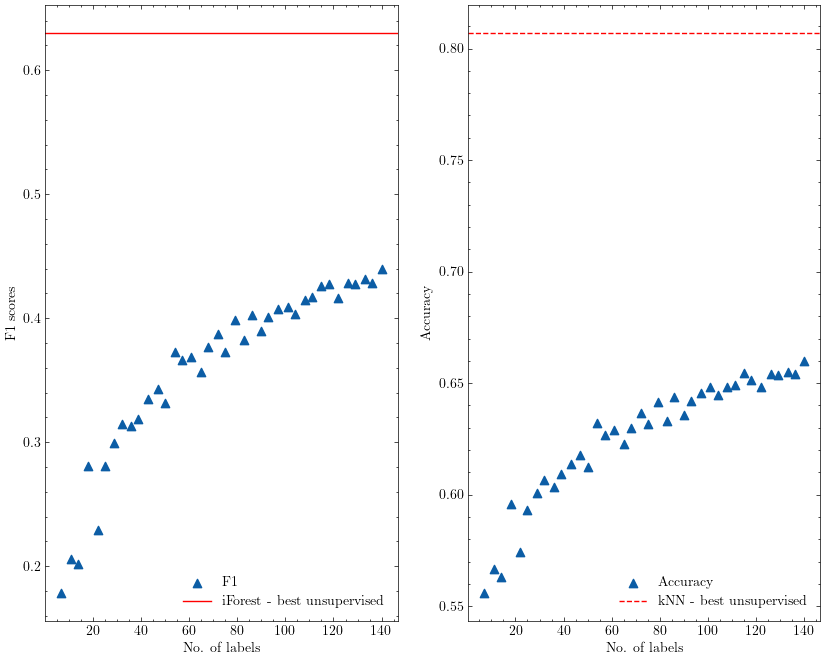

In [18]:
fig, ax = plt.subplots(1,2, figsize=(10,8))

ax[0].scatter(
    label_counts,
    f1_scores,
    label="F1",
    marker="^"
)

ax[0].axhline(0.630, c="r", label="iForest - best unsupervised")
#ax[0].axhline(0.704759, c="g", label="iForest")

ax[0].set_ylabel("F1 scores")
ax[0].set_xlabel("No. of labels")
ax[0].legend()

ax[1].scatter(
    label_counts,
    acc_scores,
    label="Accuracy",
    marker="^"
)
ax[1].axhline(0.807, c="r", ls="--", label="kNN - best unsupervised")
#ax[1].axhline(0.849143, c="g", label="iForest")

ax[1].set_ylabel("Accuracy")
ax[1].set_xlabel("No. of labels")
ax[1].legend()